# 뉴스 기사 분류 모델을 LIME 으로 해석해보자!

- 뉴스 기사 데이터를 20가지로 카테고리로 분류하는 분류기 만들기
- [Lime Text Explainer](https://github.com/marcotcr/lime/blob/fd7eb2e6f760619c29fca0187c07b82157601b32/lime/lime_text.py#L301) 함수 활용하여 개별 예측에 대한 features 들을 살펴보고 해석해보자


## 패키지 설치

In [1]:
!pip install lime

     |████████████████████████████████| 275 kB 20.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=563fc6404f456d569109db3f774cd08fa3888d4b8d6f5f7fcf09f550cc6857db
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [2]:
import lime
import sklearn
import sklearn.ensemble
import sklearn.metrics
import pandas as pd
import numpy as np

## 데이터 불러와 분류기 만들기

### [20개의 뉴스그룹 데이터](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups)를 분류하는 분류기를 만들어 라임을 적용해보자

In [3]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
# making class names shorter
class_names = [x.split('.')[-1] if 'misc' not in x else '.'.join(x.split('.')[-2:]) for x in newsgroups_train.target_names]
class_names[3] = 'pc.hardware'
class_names[4] = 'mac.hardware'

In [4]:
# fetch_20newsgroups 객체는 dictionary 형태로 5개의 key를 가지고 있음
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

### 학습셋 데이터프레임화해서 살펴보기

In [5]:
df = pd.DataFrame({'data': newsgroups_train['data'], 'target': newsgroups_train['target']})
print(df.shape)
df.head()

(11314, 2)


data  target
0  From: lerxst@wam.umd.edu (where's my thing)\nS...       7
1  From: guykuo@carson.u.washington.edu (Guy Kuo)...       4
2  From: twillis@ec.ecn.purdue.edu (Thomas E Will...       4
3  From: jgreen@amber (Joe Green)\nSubject: Re: W...       1
4  From: jcm@head-cfa.harvard.edu (Jonathan McDow...      14

### 뉴스 주제는 아래와 같이 **20개의 카테고리**인 것으로 확인됩니다

In [6]:
print(' , '.join(class_names))

atheism , graphics , ms-windows.misc , pc.hardware , mac.hardware , x , misc.forsale , autos , motorcycles , baseball , hockey , crypt , electronics , med , space , christian , guns , mideast , politics.misc , religion.misc


### TFIDF vectorizer로 텍스트 transform 시키기

In [7]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

### Multinomial Naive Bayes 으로 분류기 만들기

In [8]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=.01)
nb.fit(train_vectors, newsgroups_train.target)

MultinomialNB(alpha=0.01)

In [9]:
pred = nb.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='weighted')

0.8350184193998174

- Classifier의 F1 score 가 꽤 높은 것으로 나왔다
- 살펴보니, Multinomial Naive Bayes 가 관련없는 headers 같은 데이터들을 포함해 오버피팅 한 것으로 나타난다
- LIME 으로 각각의 예측에 대해 해석해보자

## LIME 으로 예측 설명하기

### 위 과정을 pipeline 으로 만들고 test dataset의 데이터 하나에 대한 확률 예측값을 출력해보자

In [10]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, nb)

In [11]:
print(c.predict_proba([newsgroups_test.data[0]]).round(3))

[[0.001 0.01  0.003 0.047 0.006 0.002 0.003 0.521 0.022 0.008 0.025 0.
  0.331 0.003 0.006 0.    0.003 0.    0.001 0.009]]


### LIME Text Explainer 호출

In [12]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

### 레이블 생성

In [13]:
idx = 1340
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6, labels=[0, 15])
print('Document id: %d' % idx)
print('Predicted class =', class_names[nb.predict(test_vectors[idx]).reshape(1, -1)[0, 0]])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

Document id: 1340
Predicted class = atheism
True class: atheism


### 각각 다른 레이블에 대한 설명(explanations)을 살펴보자
### 특정 데이터 포인트의 각각의 feature 를 통해 (중요도순) 예측을 설명하고자 한다


- 'Caused' 라는 단어가 class 0 (atheism)이라 분류될 경향이 더 높다고 설명하는 반면,
- 'Caused' 는 class 15(christian) 이라 분류될 경향이 없다고 설명한다.

- ***같은 단어가 다르게 분류될 경향을 반대로 설명하는 경우가 종종 있음***

In [14]:
print('Explanation for class %s' % class_names[0])
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class %s' % class_names[15])
print('\n'.join(map(str, exp.as_list(label=15))))

Explanation for class atheism
('Caused', 0.2664631329233221)
('Rice', 0.1388659853159246)
('Genocide', 0.11850084848969958)
('scri', -0.08616116419851826)
('Semitic', -0.08459226434726129)
('owlnet', -0.08441693690435886)

Explanation for class christian
('Caused', -0.18957189096437296)
('scri', 0.09373800977757228)
('Genocide', -0.09244341684664563)
('fsu', 0.08712206812161498)
('Semitic', 0.08361913723861618)
('Luther', 0.0803211515659374)


### 레이블을 만드는 또다른 방법으로는 top K 클래스에 대해 레이블을 만드는 것이다
아래 예시는 K=2 일 때이고, 어떤 label 들이 해석/설명 하고 있는지 보고 싶으면 ```available_labels``` 함수를 이용하면 된다

In [15]:
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6, top_labels=2)
print(exp.available_labels())

[0, 15]


## Explanation Sample 1)

- 왼쪽 패널 ▶ MNB Model 은 아래 샘플이 "Atheism"(무신론) 일 거라고 50% 예측했다
- 중앙 패널 ▶ 특정 데이터 포인트의 각각의 feature 를 통해 (중요도순) 예측을 설명하고자 한다
  - 'caused', 'rice', 'genocide' 단어들 이 뉴스(sample)가 "Atheism"으로 분류되어야 한다고 설명하고 있다
  - 동시에 'caused', 'genocide' 단어들이 이 뉴스가 "christian" 으로 분류되지 말아야 한다 설명하고 있다 (위 설명과 일치하는 경향) -> 따라서 두 단어들이 atheism 에 긍정적이고, christian 에 부정적인 설명을 더하는 단어들이다고 판단할 수 있겠다
*- note: 그렇다고 꼭 각기 다른 분류 클래스에 대해 상반된 설명을 갖고 있다는 법을 없다 (+/-)*

In [16]:
exp.show_in_notebook(text=False)

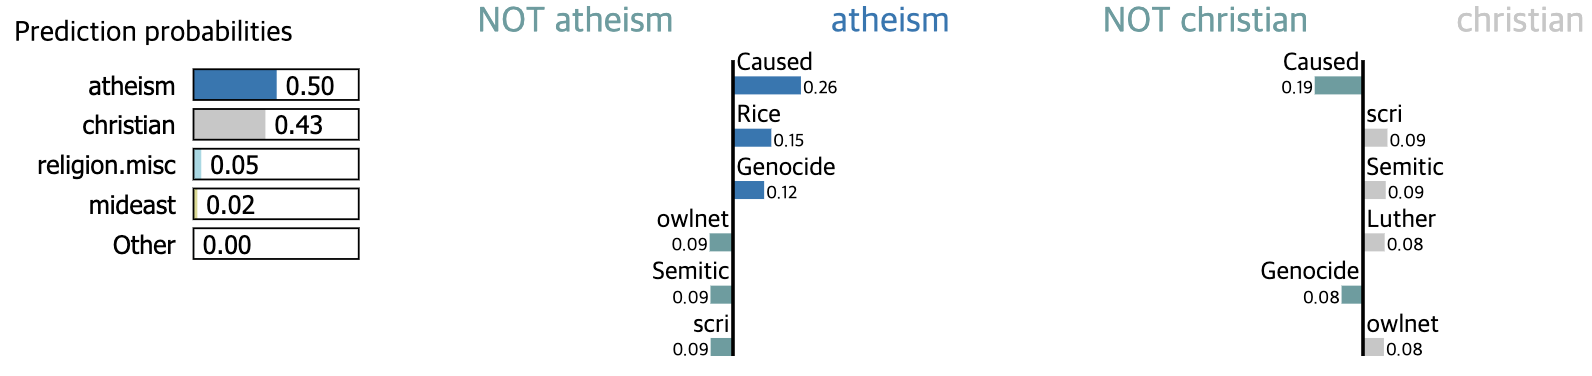

### 본문을 함께 보면 설명력을 더해주는 단어들과 주목하지 않아도 될 것 같은 단어들이 눈에 보이기 시작한다

- Reasonable: 'Genocide', 'Luther'(종교 개혁/신학 지도자), 'Semitic'(유대교적) 단어들은 종교 관련된 단어들로 본문의 분류클래스들과 관련이 있게 이해된다

- Unreasonable: 'Rice', 'Owlnet' 단어들은 Rice University 고유명칭이므로 일반 명사로 해석하면 안 될뿐 더러, Rice Univ. symbol이 owl(부엉이)라 데이터의 email 부분에 사용된 것으로 이해된다

- Conclusion: 따라서 atheism(무신론) 이라 분류된다/안된다를 설명하는 단어들이 중앙 패널과 같이 확률이 큰 순으로 나열 되어 있다 하더라도, 모든 단어들의 분류예측에 대한 설명력을 신뢰하고 해석하기는 힘들 것 같다

In [17]:
exp.show_in_notebook(text=newsgroups_test.data[idx], labels=(0,))

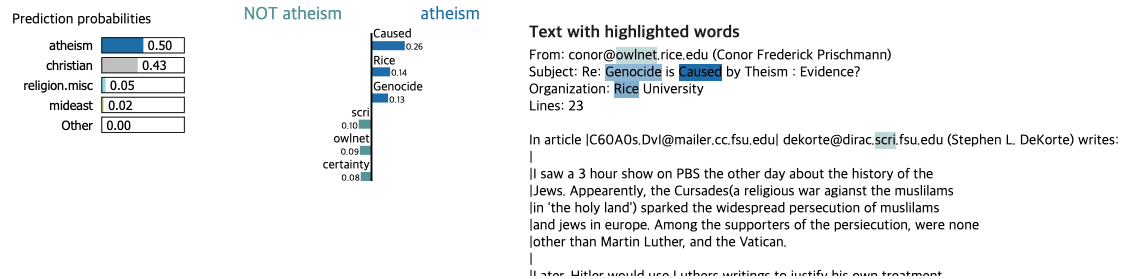

### Thoughts / To-Do

- highlighted 된 부분들이 주로 header / subject line 에서 나오는 거 같고,
rice univ. 와 owl 처럼 오해를 불러 일으킬 만한 email 이나 학교 이름 같은 고유 명칭은 filter 해서 해보면 설명력이 더 좋아질까?

## 불필요한 정보들을 제거한 후에 다시 해석해보자: excluding headers, footers, and quotes
`remove` parameter 를 활용하여 headers, footers, quotes 를 제외하고 다시 학습시키면 결과가 어떻게 달라질까


In [18]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)
nb = MultinomialNB(alpha=.01)
nb.fit(train_vectors, newsgroups_train.target)
c = make_pipeline(vectorizer, nb)
explainer = LimeTextExplainer(class_names=class_names)

### features 변화를 보기 위해 Visualization 결과에 나오는 feature 갯수를 10개로 늘려보자

In [19]:
print(idx)
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=10, top_labels=2)
print(exp.available_labels())

1340
[15, 17]


## Explanation Sample 2)

- 왼쪽 패널 ▶ MNB Model 은 이 샘플 뉴스가 "Christian"(기독교) 일 거라고 40% 의 예측률로 분류하고 있으며, 뒤이어 38%의 예측률로 "Mideast"(중동) 카테고리에 분류된다고 보여준다
  - Sample 1 에서는 1순위(50%) "Atheism"(무신론), 2순위(43%) "Christian" 라고 분류했었던 점을 고려해보면, Atheism 으로 분류되는데 일조(?)했던 features 들이 지금은 제외되었다
  - 즉, 'Atheism 분류'를 support 하는 features 들은 headers/footers/quotes 에 포함되어 있었던 것으로 이해된다

- 중앙 패널 ▶ 특정 데이터 포인트의 각각의 feature 를 통해 (중요도순) 예측을 설명하고자 한다
  - 'Luther', 'Catholic', 'doctrine' 단어들 이 뉴스(sample)가 "Christian"으로 분류되어야 한다고 설명하고 있다
  - 반면 'deer', 'Heck' 단어들은 이 뉴스가 "christian" 으로 분류되지 말아야 하고, 동시에 "mideast"로 분류되어야한다고 설명하고 있다
  - 따라서 이 단어들이 christian 에 부정적이고, mideast 에 긍정적인 설명을 더하는 단어들이다고 판단할 수 있겠다 -> ***항상 상반된 설명을 한다는 법은 없지만 이 경우는 해당되는 케이스***

In [20]:
exp.show_in_notebook(text=False)

### 본문과 함께 보자

**Reasonable: Christian 으로 분류되어야한다는 features 과 분류되면 안된다는 features 모두 꽤 reasonable 해 보인다**  

> 사실 해석하기 나름일 수도 있다. 아래 단어들을 함께 살펴보자


  - **Christian 으로 분류되어야 한다** : 'Luther'(종교 개혁/신학 지도자), 'Catholic'(카톨릭), 'doctrine'(교리), 'Semitic'(유대교적) 단어들은 기독교 관련 단어들이므로, 분류 클래스와 관련이 있다고 이해된다

  - **NOT Christian 으로 분류되어야 한다** :'deer', 'Heck', 'anti', 'shot' 등 단어들이 기독교가 아니라고 분류하는 데 설명하고 있는데, 그렇게 해석할 수 있다고 생각이 든다. 

- **Conclusion**: 해당 샘플 데이터가 Christian(기독교)로 분류되어야 한다고 설명하는 단어들이 본문 내용과 함께 살펴볼 때, 꽤 근거있게 설명이 되지만, 모든 features 들에 대해 설명력을 기대할 수는 없으니 ***본문 내용을 이해하며 필요한 features 들만 선택하여 해석하는 것이 활용성 면에서 키포인트 라고 생각된다***

- individual word 가 feature 이다 보니, 문맥을 고려하지 않는 한계가 보인다
  - "Jews should be shot like deer." 는 결국 Jews 에 대한 표현이지만, 'shot', 'deer' 단어 별개로 볼 때 'Jews'과 관련없다고 해석하고 있다

In [21]:
exp.show_in_notebook(text=newsgroups_test.data[idx], labels=(15,))

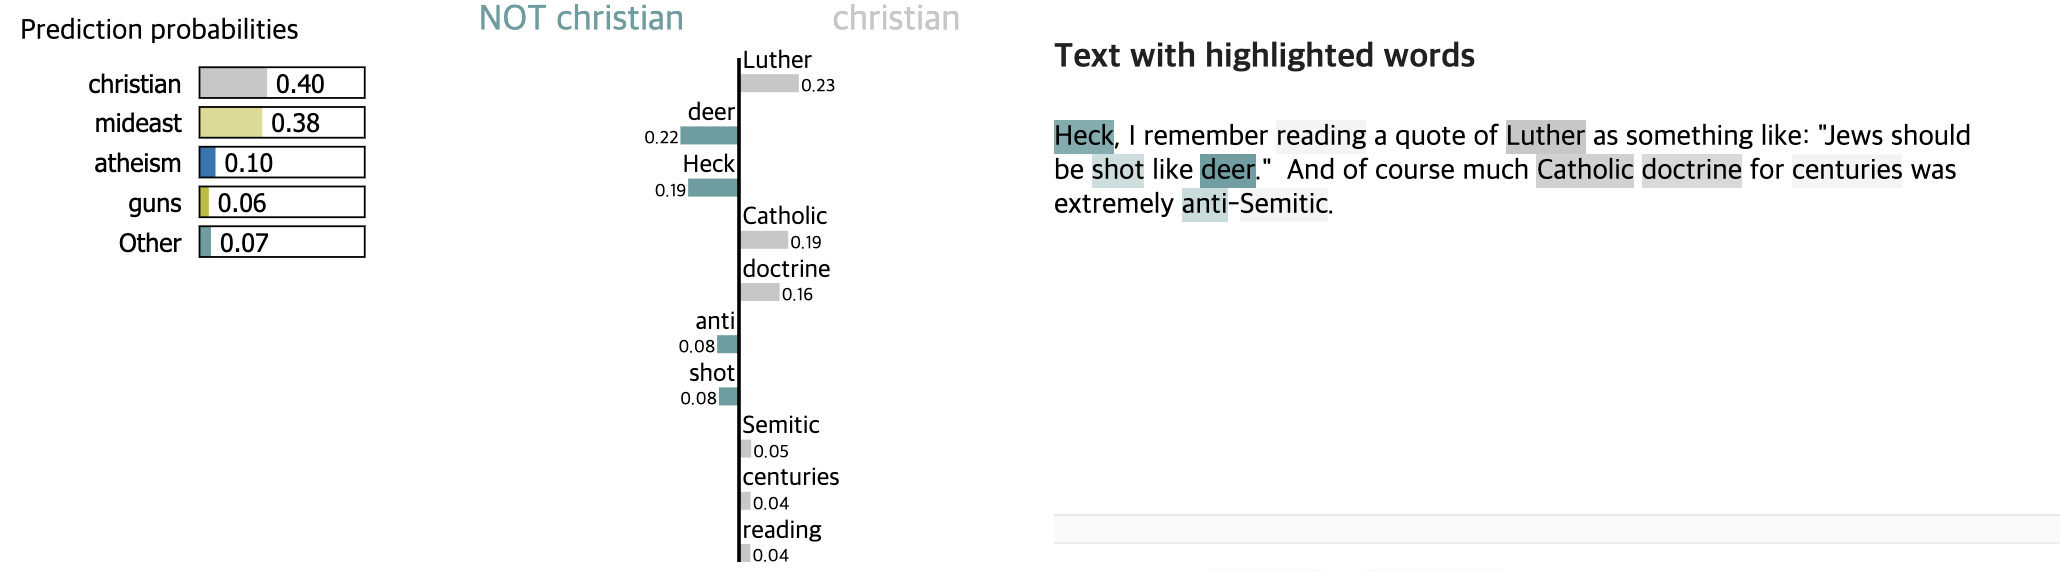

## SP-LIME Implementation

SP-LIME은 꼭 봐야할만한 인스턴스들을 뽑아주는(Pick) 방법론
중복되는 정보를 포함하는 인스턴스는 최대한 추려내고 다양한 특성을 지닌 인스턴스를 포함하도록 뽑는다. SP-LIME으로 뽑힌 subset의 explanation 을 보고 모델 전반적인 작동 방식을 신뢰할 것인지 평가

In [22]:
import warnings
from lime import submodular_pick

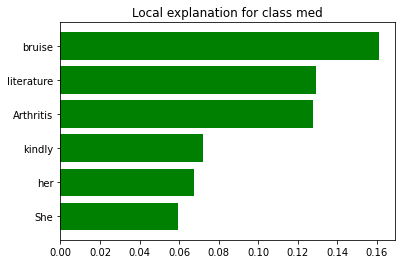

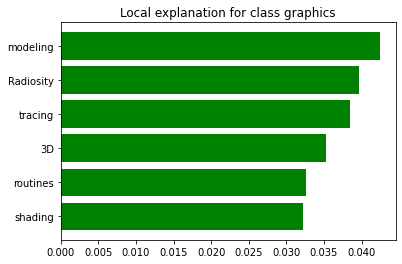

In [23]:
# SP-LIME returns exaplanations on a sample set to provide a non redundant global decision boundary of original model
sp_obj = submodular_pick.SubmodularPick(explainer, newsgroups_test.data, c.predict_proba, sample_size=2, num_features=6, num_exps_desired=2)


[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];
